# Does the bootstrap methodology have the capability to replicate real world resampling of training dataset?

When a statistical learning method is fit on a training dataset the parameters of the model are determined. However there is an uncertainty associated with the parameter values as a different training dataset will lead to slightly different parameter values. For cases where this uncertainty cannot be estimated via analytical methods a practical approach will be to resample the training dataset multiple times and fit the model to get its parameter values thereby eventually estimating the associated uncertainty. However almost always such resampling of the training set is not possible and here the bootstrap methodology comes in. The methodology assumes that it can well replicate the variance of the training dataset. It is this assumption that we would like to empirically test.

## Measuring variance of training datasets

One training dataset varies from the other. But how to quantify this difference (let us assume a training set with $n_{samples}$ samples of a single feature)?  For this we can take two approaches -

<ol>
    <li>We can either characterise each training set by a certain number of features like mean, variance, quartile points. Then the variance of the training sets can be studied by studying the variances of the sets of these features.</li>
    <li>Each training set will give us a histogram plot. We can form a metric that will measure the dissimilarity of the histogram plots between two training sets to quantify the difference of the two training sets. Such differences between all pairs of training sets among $n_{sets}$ training sets will also help us study the variance of training sets.</li>
    </ol>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
def discretizeSeriesCount(ser,gap,precision):
    lowerEnd = np.floor(ser.min()*(10**precision))/(10**precision)-(gap/2)
    upperEnd = np.ceil(ser.max()*(10**precision))/(10**precision)+gap
    bins = np.arange(lowerEnd,upperEnd,gap)
    labels = np.around(np.arange(lowerEnd+(gap/2),upperEnd-(gap/2),gap),precision)
    return pd.cut(ser,bins,labels=labels).value_counts()

def dissimilarityMetric(x1,x2,gap,precision):
    ser1=discretizeSeriesCount(x1,gap,precision)
    ser2=discretizeSeriesCount(x2,gap,precision)
    return (ser1.subtract(ser2,fill_value=0)**2).sum()

def generatingTrainingSets(numOfSets,func,*args,**kwargs):
    return [func(*args,**kwargs) for i in range(numOfSets)]

def generatingBootstrapSets(y,numOfSets):
    return [np.random.choice(y,size=len(y)) for i in range(numOfSets)]

def findVariability(gap,precision,numOfSets,func,*args,**kwargs):
    trainingSets = generatingTrainingSets(numOfSets,func,*args,**kwargs)
    bootstrapSets = generatingBootstrapSets(trainingSets[0],numOfSets)
    
    meansOfTrainingSets = [trainingSet.mean() for trainingSet in trainingSets]
    meansOfbootstrapSets = [bootstrapSet.mean() for bootstrapSet in bootstrapSets]
    
    trainingQ0,trainingQ25,trainingQ50,trainingQ75,training100 = np.quantile(trainingSets,[0.0,0.25,0.50,0.75,1.0],axis=-1)
    bootstrapQ0,bootstrapQ25,bootstrapQ50,bootstrapQ75,bootstrapQ100 = np.quantile(bootstrapSets,[0.0,0.25,0.50,0.75,1.0],axis=-1)
    
    trainingSTDs = np.std(trainingSets,axis=-1)
    bootstrapSTDs = np.std(bootstrapSets,axis=-1)
    
    trainingDissimilarities = []
    for i in range(len(trainingSets)):
        for j in range(i+1, len(trainingSets)):
            trainingDissimilarities.append(dissimilarityMetric(trainingSets[i],trainingSets[j],gap,precision))
    
    bootstrapDissimilarities = []
    for i in range(len(bootstrapSets)):
        for j in range(i+1,len(bootstrapSets)):
            bootstrapDissimilarities.append(dissimilarityMetric(bootstrapSets[i],bootstrapSets[j],gap,precision))
    
    trainingProps = {
        'mean':meansOfTrainingSets,
        'Q0':trainingQ0,
        'Q25':trainingQ25,
        'Q50':trainingQ50,
        'Q75':trainingQ75,
        'Q100':training100,
        'STD':trainingSTDs,
        'dissimilarityMetric':trainingDissimilarities
    }
    
    bootstrapProps = {
        'mean':meansOfbootstrapSets,
        'Q0':bootstrapQ0,
        'Q25':bootstrapQ25,
        'Q50':bootstrapQ50,
        'Q75':bootstrapQ75,
        'Q100':bootstrapQ100,
        'STD':bootstrapSTDs,
        'dissimilarityMetric':bootstrapDissimilarities
    }
    
    return trainingProps,bootstrapProps

In [3]:
trainingProps, bootstrapProps = findVariability(0.1,1,100,np.random.uniform,low=0.0,high=10.0,size=1000)

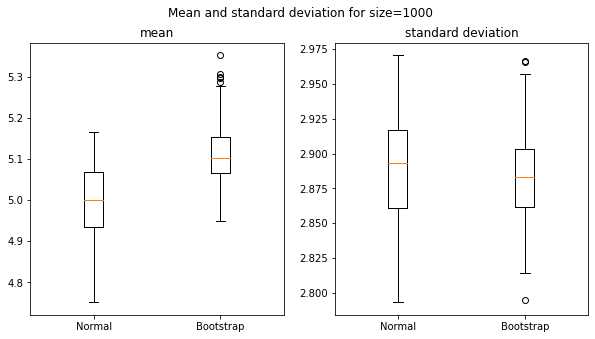

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.boxplot([trainingProps['mean'],bootstrapProps['mean']],labels=['Normal','Bootstrap'])
ax1.set_title('mean')
ax2.boxplot([trainingProps['STD'],bootstrapProps['STD']],labels=['Normal','Bootstrap'])
ax2.set_title('standard deviation')
fig.suptitle('Mean and standard deviation for size=1000')
fig.savefig('C:/Users/bubai/ISLRLearning/LabWork/Notebook/Blog requirements/Capability of bootstrap/Mean_and_STD_Size_1000')

''

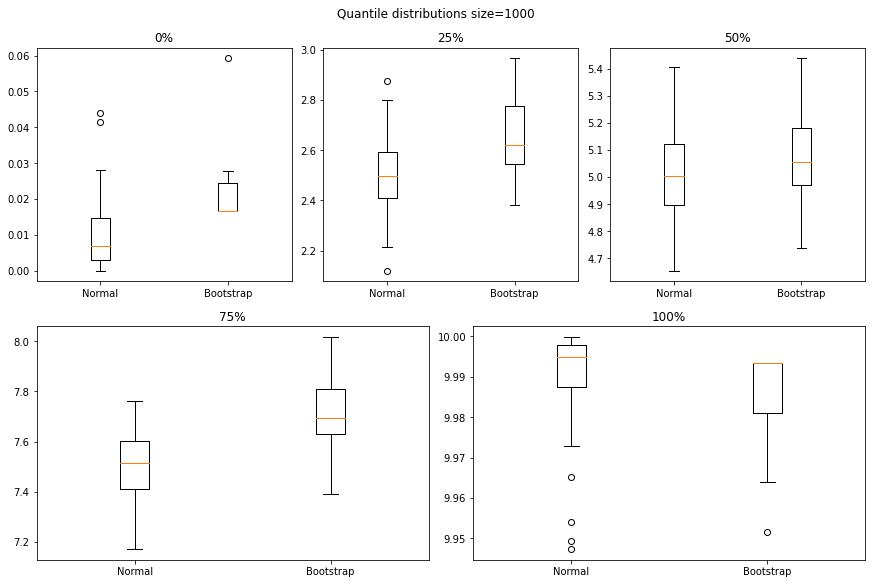

In [5]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = GridSpec(2, 6, figure=fig)
ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0,2:4])
ax3 = fig.add_subplot(gs[0,4:])
ax4 = fig.add_subplot(gs[1,:3])
ax5 = fig.add_subplot(gs[1,3:])
ax1.boxplot([trainingProps['Q0'],bootstrapProps['Q0']],labels=['Normal','Bootstrap'])
ax1.set_title('0%')
ax2.boxplot([trainingProps['Q25'],bootstrapProps['Q25']],labels=['Normal','Bootstrap'])
ax2.set_title('25%')
ax3.boxplot([trainingProps['Q50'],bootstrapProps['Q50']],labels=['Normal','Bootstrap'])
ax3.set_title('50%')
ax4.boxplot([trainingProps['Q75'],bootstrapProps['Q75']],labels=['Normal','Bootstrap'])
ax4.set_title('75%')
ax5.boxplot([trainingProps['Q100'],bootstrapProps['Q100']],labels=['Normal','Bootstrap'])
ax5.set_title('100%')
fig.suptitle('Quantile distributions size=1000')
fig.savefig('C:/Users/bubai/ISLRLearning/LabWork/Notebook/Blog requirements/Capability of bootstrap/Quantiles_Size_1000')
;

''

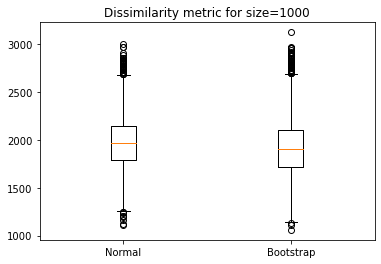

In [6]:
fig, ax1 = plt.subplots()
ax1.boxplot([trainingProps['dissimilarityMetric'],bootstrapProps['dissimilarityMetric']],labels=['Normal','Bootstrap'])
ax1.set_title('Dissimilarity metric for size=1000')
fig.savefig('C:/Users/bubai/ISLRLearning/LabWork/Notebook/Blog requirements/Capability of bootstrap/DissimilarityMetric_Size_1000')
;

In [7]:
trainingProps, bootstrapProps = findVariability(0.1,1,100,np.random.uniform,low=0.0,high=10.0,size=10)

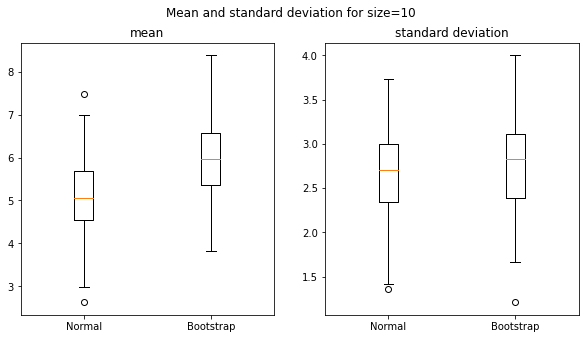

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.boxplot([trainingProps['mean'],bootstrapProps['mean']],labels=['Normal','Bootstrap'])
ax1.set_title('mean')
ax2.boxplot([trainingProps['STD'],bootstrapProps['STD']],labels=['Normal','Bootstrap'])
ax2.set_title('standard deviation')
fig.suptitle('Mean and standard deviation for size=10')
fig.savefig('C:/Users/bubai/ISLRLearning/LabWork/Notebook/Blog requirements/Capability of bootstrap/Mean_and_STD_Size_10')

''

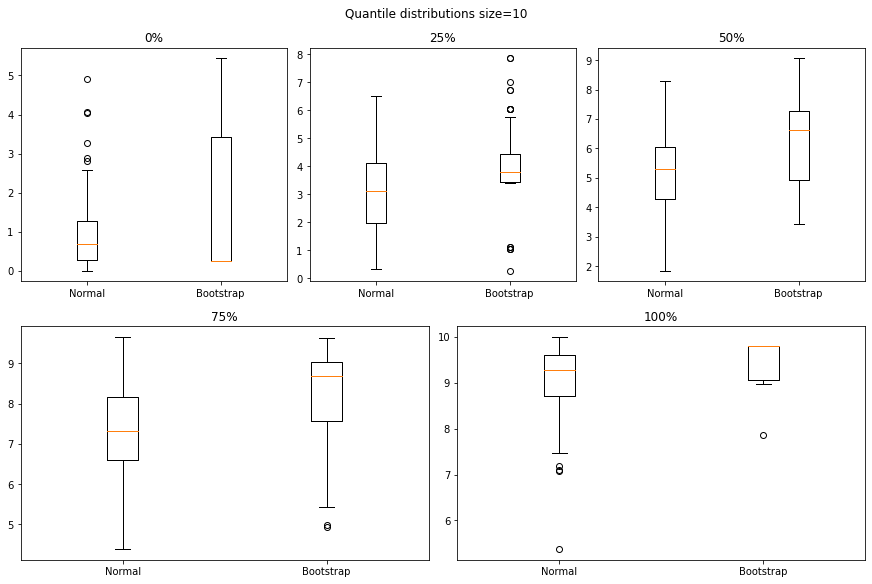

In [9]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = GridSpec(2, 6, figure=fig)
ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0,2:4])
ax3 = fig.add_subplot(gs[0,4:])
ax4 = fig.add_subplot(gs[1,:3])
ax5 = fig.add_subplot(gs[1,3:])
ax1.boxplot([trainingProps['Q0'],bootstrapProps['Q0']],labels=['Normal','Bootstrap'])
ax1.set_title('0%')
ax2.boxplot([trainingProps['Q25'],bootstrapProps['Q25']],labels=['Normal','Bootstrap'])
ax2.set_title('25%')
ax3.boxplot([trainingProps['Q50'],bootstrapProps['Q50']],labels=['Normal','Bootstrap'])
ax3.set_title('50%')
ax4.boxplot([trainingProps['Q75'],bootstrapProps['Q75']],labels=['Normal','Bootstrap'])
ax4.set_title('75%')
ax5.boxplot([trainingProps['Q100'],bootstrapProps['Q100']],labels=['Normal','Bootstrap'])
ax5.set_title('100%')
fig.suptitle('Quantile distributions size=10')
fig.savefig('C:/Users/bubai/ISLRLearning/LabWork/Notebook/Blog requirements/Capability of bootstrap/Quantiles_Size_10')
;

''

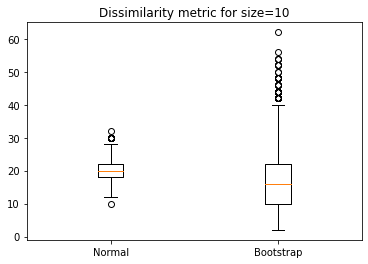

In [10]:
fig, ax1 = plt.subplots()
ax1.boxplot([trainingProps['dissimilarityMetric'],bootstrapProps['dissimilarityMetric']],labels=['Normal','Bootstrap'])
ax1.set_title('Dissimilarity metric for size=10')
fig.savefig('C:/Users/bubai/ISLRLearning/LabWork/Notebook/Blog requirements/Capability of bootstrap/DissimilarityMetric_Size_10')
;